In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import sys
from collections import Counter
import gget
import scipy
from sklearn import preprocessing
import umap

import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

2024-01-12 08:21:09.309649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 08:21:24.924769: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 08:21:48.309694: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-12 08:21:48.310166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

In [2]:
umap.__file__

'/home/cstansbu/.local/lib/python3.9/site-packages/umap/__init__.py'

# Load our data

In [3]:
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run3/scanpy/anndata_distance.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run4/scanpy/anndata_distance.h5ad"
fpath = "/scratch/indikar_root/indikar1/cstansbu/all_HSC/scanpy/anndata_distance.h5ad"

adata = sc.read_h5ad(fpath, cache=False)
adata.obs['cluster_name'] = adata.obs['clusters'].apply(lambda x: f"C{int(x) + 1}")
adata

/home/cstansbu/.local/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 8475 × 14753
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'clusters', 'cluster_name', 'UMAP 1', 'UMAP 2', 'Fibroblast_mean', 'Fibroblast_max', 'Fibroblast_argmax', 'Fibroblast_highest_exp', 'HSC_mean', 'HSC_max', 'HSC_argmax', 'HSC_highest_exp'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_name_colors', 'clusters_colors', 'clusters_sizes', 'dendrogram_cluster_name', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

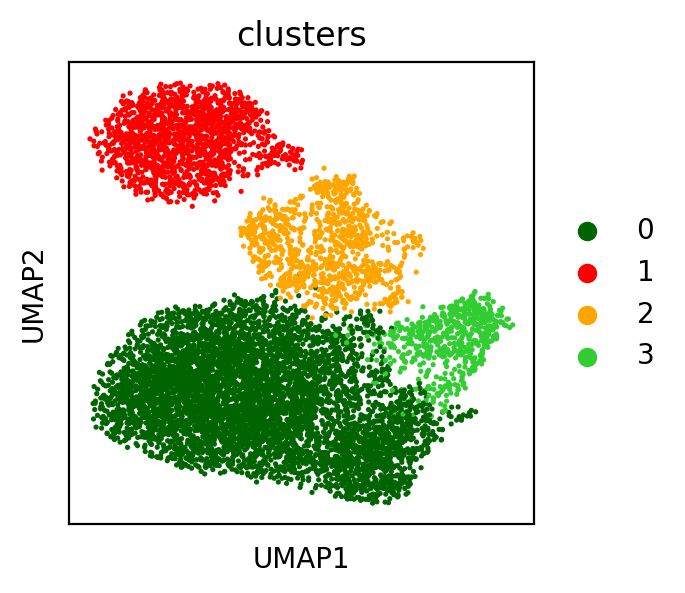

In [4]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(adata, color='clusters')

# Load tabula sapiens

In [5]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/adaptive_sampling/data/tabula_sapiens_filtered.h5ad"
sdf = sc.read_h5ad(fpath)

sc.pp.normalize_total(sdf, target_sum=1e6)

sdf

AnnData object with n_obs × n_vars = 27346 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'log1p', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

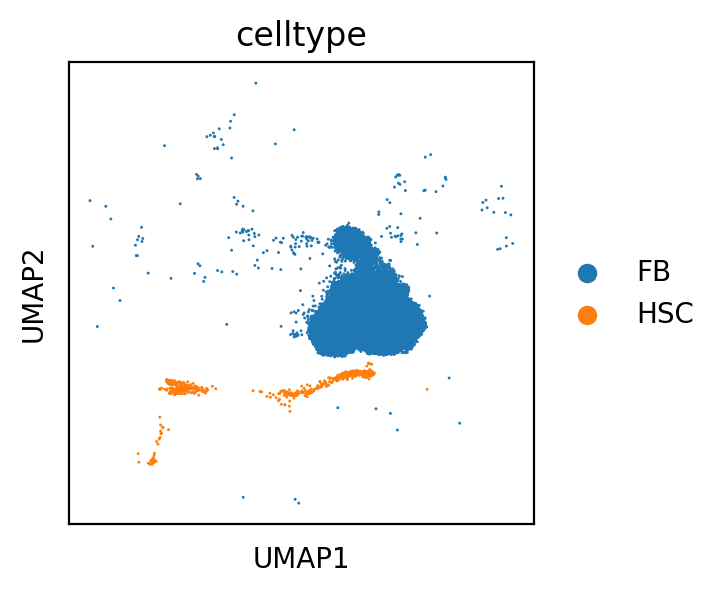

In [6]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(sdf, color='celltype')

In [7]:
sdf.obs[['celltype', 'organ_tissue']].value_counts()

celltype  organ_tissue   
FB        Fat                8459
          Vasculature        5867
          Bladder            5557
          Thymus             3924
          Trachea            1239
          Large_Intestine     953
HSC       Bone_Marrow         617
FB        Tongue              251
          Prostate            223
          Small_Intestine     113
HSC       Spleen               73
          Blood                70
dtype: int64

# Marker genes

In [8]:
def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]
    return genes['official gene symbol'].to_list()


pdfPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
pandDf = pd.read_csv(pdfPath, sep="\t")

fb = getGenes(pandDf, 'Fibroblasts')
hp = getGenes(pandDf, 'Hematopoietic stem cells')

print(f"FB genes: {len(fb)}")
print(f"HP genes: {len(hp)}")

FB genes: 179
HP genes: 88


# get minimal overlapping gene set

In [9]:

ref_genes = sdf.var.copy()
data_genes = adata.var.copy()
data_genes = data_genes.reset_index(drop=False)


gene_df = pd.merge(data_genes[['gene_name', 'gene_id']],
                   ref_genes[['gene_symbol',]],
                   how='left',
                   left_on='gene_name',
                   right_on='gene_symbol')

gene_df['is_fb_marker'] = np.where(gene_df['gene_name'].isin(fb), True, False)
gene_df['is_hsc_marker'] = np.where(gene_df['gene_name'].isin(hp), True, False)

print(gene_df['is_fb_marker'].value_counts())
print()
print(gene_df['is_hsc_marker'].value_counts())
print()

gene_df.head()

False    14644
True       135
Name: is_fb_marker, dtype: int64

False    14708
True        71
Name: is_hsc_marker, dtype: int64



,gene_name,gene_id,gene_symbol,is_fb_marker,is_hsc_marker
0,ATAD3B,ENSG00000160072,ATAD3B,False,False
1,SKI,ENSG00000157933,SKI,False,False
2,PEX14,ENSG00000142655,PEX14,False,False
3,PLCH2,ENSG00000149527,PLCH2,False,False
4,SPSB1,ENSG00000171621,SPSB1,False,False


In [10]:
# break

# define the distance to reference signature

In [11]:
def distance_to_mean(adata, sdf, gene_df, target='hsc', metric='cosine'):
    """A function to compute the distance between our cells and the target signature
    """
    if target == 'hsc':
        marker_set = 'is_hsc_marker'
        target_type = 'HSC'
    elif target == 'fb':
        marker_set = 'is_fb_marker'
        target_type = 'FB'
    else:
        raise ValueError('`target` may be either `hsc` or `fb`')

    # define reference structure
    target_genes = gene_df[gene_df[marker_set]]
    mask = (sdf.obs['celltype'] == target_type)

    # define reference subset
    ref = sdf[mask, target_genes['gene_symbol'].to_list()]
    target_signature = ref.to_df()

    # reshape the mean expresison vector
    target_signature = target_signature.mean(axis=0)
    target_vector = target_signature.to_numpy()
    target_vector = target_vector.reshape(1, -1)

    # subset the genes and extract expression
    cells = adata[:, target_genes['gene_id'].to_list()]
    cells = cells.to_df()

    d = scipy.spatial.distance.cdist(cells, target_vector, metric=metric)
    d = pd.DataFrame(d, index=cells.index)
    d.columns = ['distance']
    return d

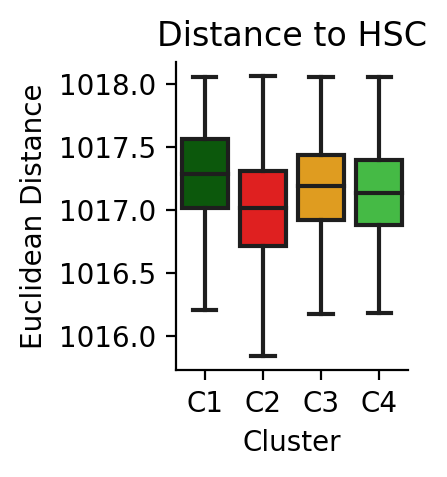

In [26]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to HSC")


sns.despine()

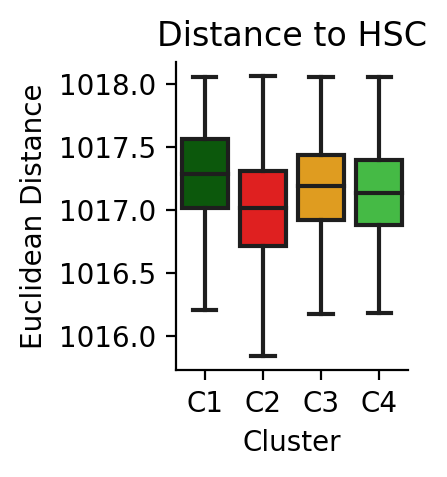

In [27]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to HSC")

sns.despine()

In [14]:
# statistical test
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)


mask = (d['cluster_name'] == 'C2')

in_group = d[mask]
out_group = d[~mask]

print(f"{in_group.shape=} {out_group.shape=}")

score, pval = scipy.stats.ttest_ind(in_group['distance'], 
                                    out_group['distance'],
                                    equal_var=False,
                                    alternative='less')

print(f"{pval=}")
print(f"{in_group['distance'].mean()=:.3f}")
print(f"{out_group['distance'].mean()=:.3f}")

in_group.shape=(1442, 18) out_group.shape=(7033, 18)
pval=8.24631280775314e-81
in_group['distance'].mean()=1016.999
out_group['distance'].mean()=1017.247


In [28]:
# statistical test
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)


mask = (d['cluster_name'] == 'C2')

in_group = d[mask]
out_group = d[~mask]

print(f"{in_group.shape=} {out_group.shape=}")

score, pval = scipy.stats.ttest_ind(in_group['distance'], 
                                    out_group['distance'],
                                    equal_var=False,
                                    alternative='greater')

print(f"{pval=}")
print(f"{in_group['distance'].mean()=:.3f}")
print(f"{out_group['distance'].mean()=:.3f}")

in_group.shape=(1442, 18) out_group.shape=(7033, 18)
pval=0.0
in_group['distance'].mean()=2351.955
out_group['distance'].mean()=2351.299


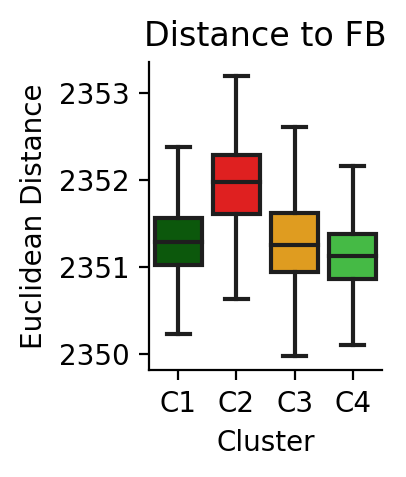

In [16]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to FB")

sns.despine()

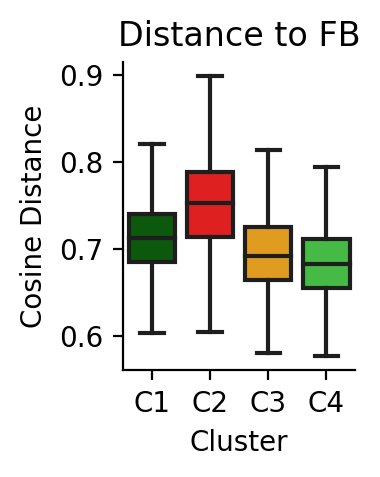

In [29]:
metric = 'cosine'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to FB")

sns.despine()

# Distance Plots

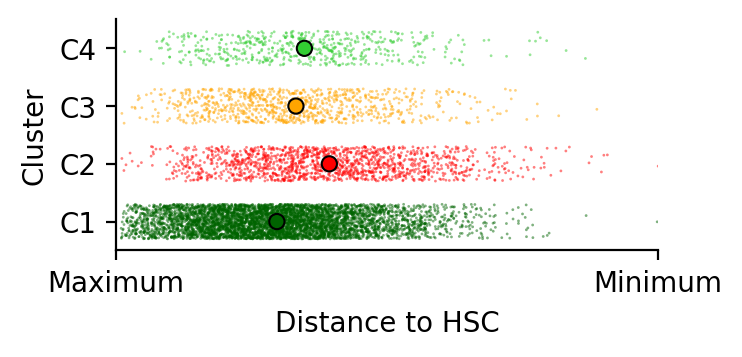

In [30]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

min_max_scaler = preprocessing.MinMaxScaler()
d['distance_norm'] = min_max_scaler.fit_transform(d['distance'].to_numpy().reshape(-1, 1))
d = d[d['distance_norm'] < 0.99]

gx = d.groupby(['cluster_name'])['distance_norm'].mean()
gx = gx.reset_index(drop=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 1.5

sns.stripplot(data=d, 
              x='distance_norm', 
              y='cluster_name',
              jitter=0.3,
              palette=list(adata.uns['clusters_colors']),
              alpha=0.5,
              zorder=1,
              size=1)

sns.scatterplot(data=gx, 
                x='distance_norm', 
                y='cluster_name',
                hue='cluster_name',
                zorder=3,
                palette=list(adata.uns['clusters_colors']),
                marker="o",
                linewidth=0.75,
                ec='k',
                s=30)

plt.gca().legend().remove()
plt.ylabel("Cluster")
plt.xlabel("Distance to HSC")
plt.gca().invert_xaxis()
plt.xticks([0, 1], ['Minimum', 'Maximum'])
plt.ylim([-0.5, 3.5])

sns.despine()

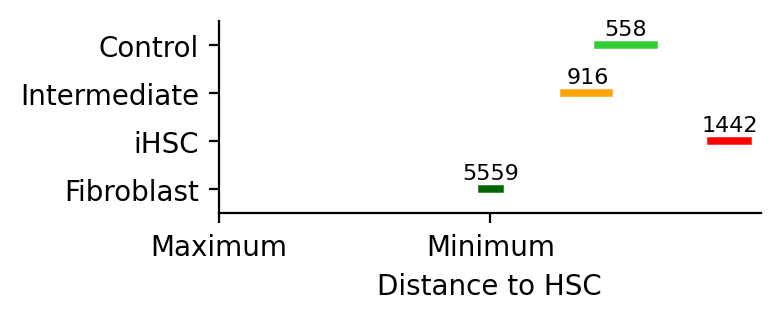

In [31]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

min_max_scaler = preprocessing.MinMaxScaler()
d['distance_norm'] = min_max_scaler.fit_transform(d['distance'].to_numpy().reshape(-1, 1))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 1.25

sns.pointplot(data=d, 
              x='distance_norm', 
              y='cluster_name',
              markers='none',
              palette=list(adata.uns['clusters_colors']),
              alpha=0.5,
              zorder=1,
              size=1)

ax = plt.gca()
plt.ylabel("")
plt.xlabel("Distance to HSC")
ax.invert_xaxis()
plt.xticks([0.71, 0.825], ['Minimum', 'Maximum'])
plt.ylim([-0.5, 3.5])
plt.yticks([0, 1, 2, 3], ['Fibroblast', 'iHSC', 'Intermediate', 'Control'])
sns.despine()

gx = d.groupby(['cluster_name'])['distance_norm'].agg(['count', 'mean'])
gx = gx.reset_index(drop=False)

for y_val, row in gx.iterrows():
    label = row['count']
    x_val = row['mean']

    nudge = y_val + 0.2

    ax.text(x_val, 
            nudge, 
            label, 
            ha='center',
            fontsize=8,)
    

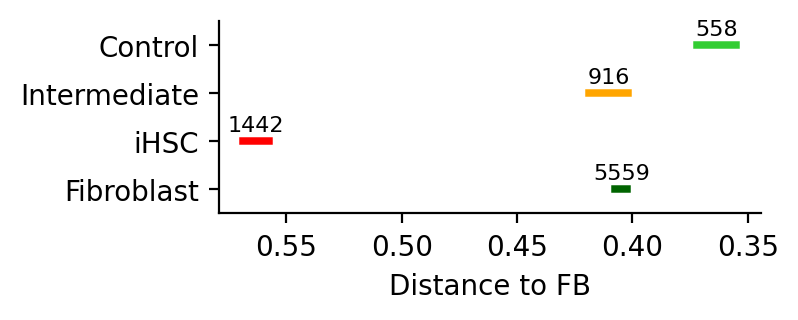

In [32]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

min_max_scaler = preprocessing.MinMaxScaler()
d['distance_norm'] = min_max_scaler.fit_transform(d['distance'].to_numpy().reshape(-1, 1))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 1.25

sns.pointplot(data=d, 
              x='distance_norm', 
              y='cluster_name',
              markers='none',
              palette=list(adata.uns['clusters_colors']),
              alpha=0.5,
              zorder=1,
              size=1)

ax = plt.gca()
plt.ylabel("")
plt.xlabel("Distance to FB")
ax.invert_xaxis()
# plt.xticks([0.53, 0.75], ['Minimum', 'Maximum'])
plt.ylim([-0.5, 3.5])
plt.yticks([0, 1, 2, 3], ['Fibroblast', 'iHSC', 'Intermediate', 'Control'])
sns.despine()

gx = d.groupby(['cluster_name'])['distance_norm'].agg(['count', 'mean'])
gx = gx.reset_index(drop=False)

for y_val, row in gx.iterrows():
    label = row['count']
    x_val = row['mean']

    nudge = y_val + 0.2

    ax.text(x_val, 
            nudge, 
            label, 
            ha='center',
            fontsize=8,)

# Distance matrices

In [34]:
gene_df.head()

,gene_name,gene_id,gene_symbol,is_fb_marker,is_hsc_marker
0,ATAD3B,ENSG00000160072,ATAD3B,False,False
1,SKI,ENSG00000157933,SKI,False,False
2,PEX14,ENSG00000142655,PEX14,False,False
3,PLCH2,ENSG00000149527,PLCH2,False,False
4,SPSB1,ENSG00000171621,SPSB1,False,False


# full distance matrices

In [21]:
def distance_to_each(adata, sdf, gene_df, target='hsc', metric='cosine'):
    """A function to compute the distance between our cells and the target signature
    """
    if target == 'hsc':
        marker_set = 'is_hsc_marker'
        target_type = 'HSC'
    elif target == 'fb':
        marker_set = 'is_fb_marker'
        target_type = 'FB'
    else:
        raise ValueError('`target` may be either `hsc` or `fb`')

    # define reference structure
    target_genes = gene_df[gene_df[marker_set]]
    mask = (sdf.obs['celltype'] == target_type)

    # define reference subset
    ref = sdf[mask, target_genes['gene_symbol'].to_list()]
    target_cells = ref.to_df()

    # subset the genes and extract expression
    cells = adata[:, target_genes['gene_id'].to_list()]
    cells = cells.to_df()

    d = scipy.spatial.distance.cdist(cells, target_cells, metric=metric)
    d = pd.DataFrame(d, index=cells.index, columns=target_cells.index)
    # print(d.shape)
    # d.columns = ['distance']
    return d

metric = 'cosine'
to_hsc = distance_to_each(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

to_fb = distance_to_each(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

print(f"{to_hsc.shape=}")
print(f"{to_fb.shape=}")


to_hsc.shape=(8475, 760)
to_fb.shape=(8475, 26586)


C1...
group_dist.shape=(5559, 760)
C2...
group_dist.shape=(1442, 760)
C3...
group_dist.shape=(916, 760)
C4...
group_dist.shape=(558, 760)


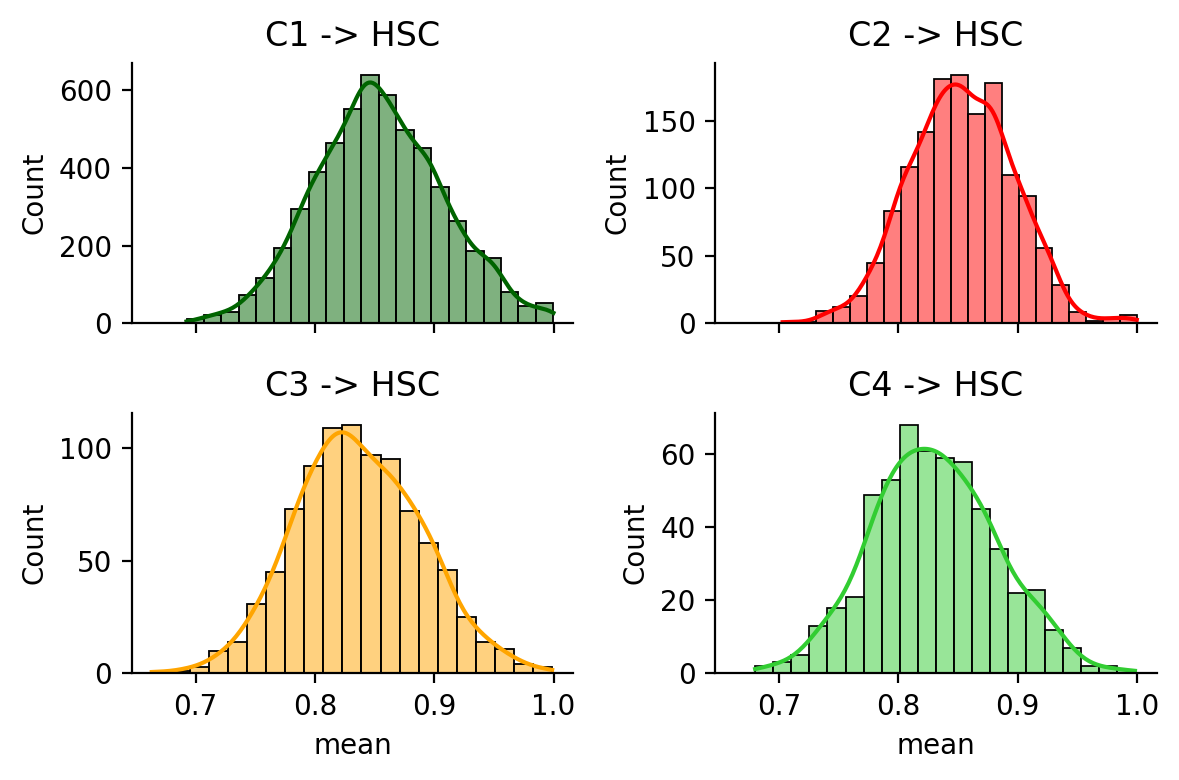

In [22]:
obs = adata.obs.copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

colors = list(adata.uns['clusters_colors'])

fig, axs = plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

for i, (cluster, group) in enumerate(obs.groupby('cluster_name')):
    print(f"{cluster}...")
    group_idx = group.index
    group_dist = to_hsc.loc[group_idx]
    print(f"{group_dist.shape=}")

    gx = group_dist.agg(['mean', 'std'], axis=1)

    sns.histplot(data=gx, 
                 x='mean',
                 bins=21,
                 kde=True,
                 color=colors[i],
                 ax=axs[i])

    axs[i].set_title(f"{cluster} -> HSC")

plt.tight_layout()
sns.despine()    

C1...
group_dist.shape=(5559, 26586)
C2...
group_dist.shape=(1442, 26586)
C3...
group_dist.shape=(916, 26586)
C4...
group_dist.shape=(558, 26586)


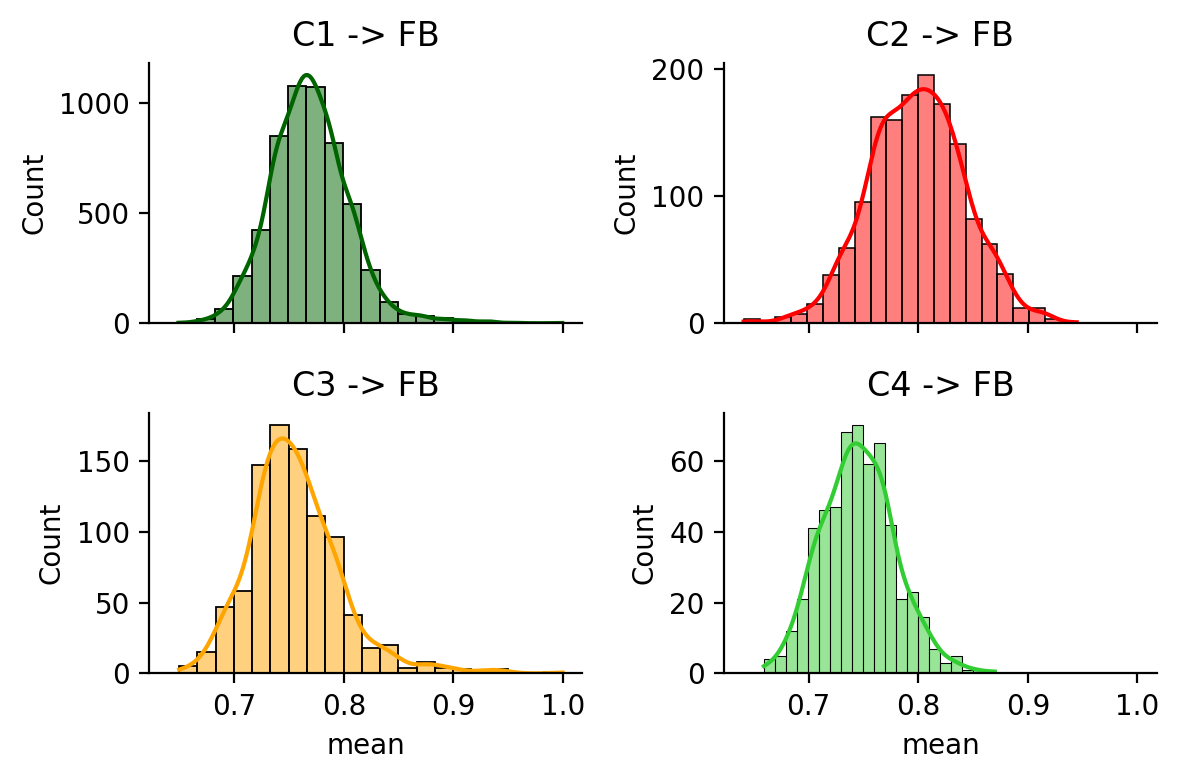

In [23]:
obs = adata.obs.copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

colors = list(adata.uns['clusters_colors'])

fig, axs = plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

for i, (cluster, group) in enumerate(obs.groupby('cluster_name')):
    print(f"{cluster}...")
    group_idx = group.index
    group_dist = to_fb.loc[group_idx]
    print(f"{group_dist.shape=}")

    gx = group_dist.agg(['mean', 'std'], axis=1)

    sns.histplot(data=gx, 
                 x='mean',
                 bins=21,
                 kde=True,
                 color=colors[i],
                 ax=axs[i])

    axs[i].set_title(f"{cluster} -> FB")

plt.tight_layout()
sns.despine()    

# paired distances

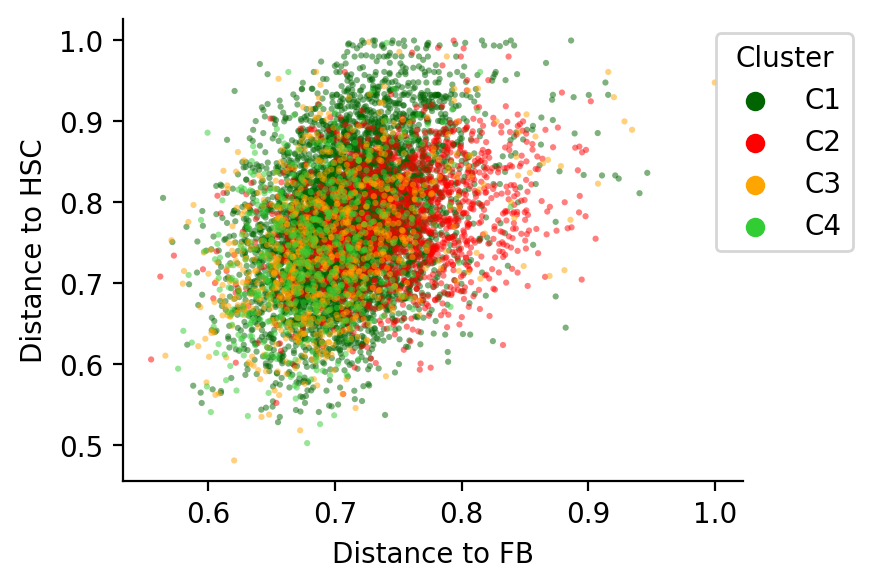

In [24]:
metric = 'cosine'
to_fb = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

to_fb.columns = ['dist_to_fb']

to_hsc = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

to_hsc.columns = ['dist_to_hsc']

dist = pd.concat([to_fb, to_hsc], axis=1)
dist = pd.merge(adata.obs, dist, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

order = np.argsort(dist['cluster_name'])

sns.scatterplot(data=dist.iloc[order], 
                x='dist_to_fb',
                y='dist_to_hsc',
                s=5,
                alpha=0.5,
                ec='none',
                palette=list(adata.uns['clusters_colors']),
                hue='cluster_name')

sns.move_legend(plt.gca(),
                loc='upper right',
                title='Cluster',
                bbox_to_anchor=(1.2, 1))

plt.ylabel('Distance to HSC')
plt.xlabel('Distance to FB')
sns.despine()

In [25]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Simple plots

In [ ]:
# define reference structure
target_genes = gene_df[gene_df['is_hsc_marker']]
mask = (sdf.obs['celltype'] == 'HSC')

# define reference subset
ref = sdf[mask, target_genes['gene_symbol'].to_list()]
target_cells = ref.to_df()

mean_exp = target_cells.mean(axis=0)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plt.plot(mean_exp.values, lw=1, c='k')


sns.despine()


# # subset the genes and extract expression
# cells = adata[:, target_genes['gene_id'].to_list()]
# cells = cells.to_df()


In [ ]:
plt.plot(target_cells.mean(axis=1))

In [ ]:
cells.head()

In [ ]:
break